In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

input = Path('input')
df_train = pd.read_csv(input / 'train.csv')
df_test = pd.read_csv(input / 'test.csv')
df_train.head()

,index,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,0,2827,911587246,18,RL,68,9241,Pave,Grvl,IR2,...,0,Gd,MnPrv,Shed,0,2,2005,WD,Normal,94946
1,3,1239,505139030,22,RL,50,6249,Pave,Grvl,Reg,...,0,Gd,MnPrv,Shed,0,5,2009,WD,Partial,162272
2,7,2768,524499845,64,RL,55,8757,Pave,Grvl,Reg,...,0,Gd,MnPrv,Shed,0,7,2009,WD,Normal,129620
3,10,2120,890941778,60,RL,43,12946,Grvl,Grvl,Reg,...,0,Gd,MnPrv,Shed,0,6,2007,WD,Normal,124625
4,11,407,902420295,64,RM,137,5902,Pave,Grvl,Reg,...,2,Gd,MnPrv,Shed,0,5,2007,WD,Normal,145879


In [2]:
print(df_train.dtypes)

index              int64
Order              int64
PID                int64
MS SubClass        int64
MS Zoning         object
                   ...  
Mo Sold            int64
Yr Sold            int64
Sale Type         object
Sale Condition    object
SalePrice          int64
Length: 81, dtype: object


In [3]:
df_train.isnull().sum()

index             0
Order             0
PID               0
MS SubClass       0
MS Zoning         0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 81, dtype: int64

In [4]:
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

In [110]:
# クロスバリデーションで使う数の設定
nr_cv = 5

#SalePriceと特徴量のログ値を使用するためのスイッチ
use_logvals = 1

#相関で使うターゲット
target = 'SalePrice_log'

#この値を超える相関をもつ列のみがML回帰モデルで使われる
min_val_corr = 0.05

#高い相関関係をもつ列を削除するスイッチ
drop_similar = 1

In [7]:
def get_best_score(grid):
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [8]:
def print_cols_large_corr(df,nr_c,targ):
    corr = df.corr()
    corr_abs = corr.abs()
    print(corr_abs.nlargest(nr_c,targ)[targ])  #nlargest(a,b):引数bの上からa番目までの値を格納

In [9]:
def plot_corr_matrix(df,nr_c,targ):
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c,targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)
    
    plt.figure(figsize=(nr_c/1.5,nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm,linewidths=1.5,annot=True,square=True,fmt='.2f',annot_kws={'size':10},
               yticklabels=cols.values,xticklabels=cols.values)
    plt.show()

In [10]:
print(df_train.shape)
print('*'*20)
print(df_test.shape)

(1200, 81)
********************
(800, 80)


In [11]:
df_train.describe()

,index,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,1200.000000,1200.000000,1.200000e+03,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,1013.075833,1838.832500,8.017210e+08,69.833333,67.870833,10603.045833,6.045833,4.562500,1969.610833,1990.040833,90.763333,705.711667,361.916667,1114.885833,888.250000,274.888333,3.473333,1313.110833,0.030833,1.064167,0.527500,2.529167,1.031667,6.555000,0.455833,1983.595000,1.353333,376.780000,76.629167,20.664167,23.525833,0.900000,15.071667,2.940000,3.475000,4.834167,2007.084167,133087.429167
std,575.726036,907.004225,1.620446e+08,44.710697,19.533572,6066.947893,1.486239,1.011738,29.118567,20.347051,178.768353,614.425757,364.152661,452.896372,366.140228,280.625578,34.506084,512.838530,0.177695,0.654782,0.517494,0.988246,0.417304,1.856479,0.660868,19.147188,0.913337,194.019414,147.664210,40.199872,71.902406,14.415669,48.942153,36.647518,49.518661,2.461717,1.362092,73353.243815
min,0.000000,0.000000,4.952863e+08,15.000000,0.000000,0.000000,1.000000,0.000000,1871.000000,1944.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000,0.000000
25%,508.750000,1040.000000,8.674117e+08,42.750000,57.750000,7580.250000,5.000000,4.000000,1952.000000,1975.000000,9.000000,73.000000,48.750000,826.750000,622.750000,0.000000,1.000000,932.500000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1973.000000,1.000000,250.750000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2006.000000,87418.000000
50%,1018.000000,2070.500000,8.880737e+08,61.000000,68.000000,9795.500000,6.000000,4.000000,1971.000000,1997.000000,15.000000,637.500000,275.000000,1075.500000,836.000000,240.500000,1.000000,1226.500000,0.000000,1.000000,1.000000,3.000000,1.000000,6.000000,0.000000,1982.500000,1.000000,356.000000,10.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,5.000000,2007.000000,122181.500000
75%,1519.250000,2605.250000,8.994243e+08,88.250000,78.000000,12183.250000,7.000000,5.000000,1994.000000,2008.000000,22.000000,1164.250000,561.250000,1358.000000,1094.000000,459.000000,2.000000,1593.250000,0.000000,1.000000,1.000000,3.000000,1.000000,8.000000,1.000000,2002.000000,2.000000,487.000000,18.000000,28.000000,5.000000,0.000000,1.000000,2.000000,0.000000,6.000000,2008.000000,163890.500000
max,1998.000000,3378.000000,9.390191e+08,225.000000,185.000000,81991.000000,11.000000,9.000000,2018.000000,2014.000000,1121.000000,2437.000000,2021.000000,3392.000000,2592.000000,1467.000000,763.000000,3314.000000,2.000000,3.000000,3.000000,7.000000,2.000000,15.000000,4.000000,2017.000000,5.000000,1135.000000,998.000000,365.000000,426.000000,386.000000,313.000000,778.000000,1278.000000,12.000000,2010.000000,498569.000000


In [12]:
df_test.describe()

,index,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
count,800.000000,800.000000,8.000000e+02,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000
mean,979.136250,1839.607500,7.882466e+08,71.328750,68.887500,10701.996250,5.907500,4.592500,1967.725000,1991.810000,88.660000,713.182500,332.050000,1138.845000,874.558750,273.780000,4.267500,1308.886250,0.036250,1.062500,0.518750,2.558750,1.057500,6.485000,0.438750,1984.181250,1.300000,377.637500,79.100000,20.92625,20.988750,0.321250,11.843750,4.771250,1.44000,4.798750,2007.003750
std,579.901688,897.131446,1.699936e+08,47.135633,21.978482,6858.896078,1.470254,1.046572,28.994529,19.342222,184.938008,609.212544,347.227524,449.138537,379.894082,288.108964,41.293673,501.741845,0.187029,0.684967,0.538527,0.936827,0.399241,1.813529,0.653285,18.897481,0.943988,176.717557,143.901579,40.95855,69.909139,1.651956,42.806101,52.780571,23.70245,2.384923,1.301289
min,1.000000,0.000000,4.969596e+08,13.000000,1.000000,0.000000,0.000000,0.000000,1873.000000,1943.000000,0.000000,0.000000,0.000000,0.000000,172.000000,0.000000,0.000000,310.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1923.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2005.000000
25%,482.750000,1041.250000,5.343741e+08,41.750000,60.000000,7534.750000,5.000000,4.000000,1951.000000,1978.750000,9.000000,75.000000,39.500000,859.250000,587.000000,0.000000,1.000000,942.750000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1974.000000,1.000000,270.500000,3.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,3.750000,2006.000000
50%,981.500000,2013.000000,8.875653e+08,61.000000,69.000000,9595.000000,6.000000,4.000000,1969.000000,1998.500000,14.000000,670.500000,246.000000,1097.000000,810.500000,225.500000,1.500000,1212.000000,0.000000,1.000000,1.000000,3.000000,1.000000,6.000000,0.000000,1983.000000,1.000000,365.000000,10.000000,0.00000,3.000000,0.000000,0.000000,1.000000,0.00000,5.000000,2007.000000
75%,1468.000000,2607.250000,9.000854e+08,91.000000,77.000000,12221.250000,7.000000,5.000000,1990.000000,2008.000000,20.000000,1159.250000,506.000000,1391.000000,1109.250000,433.250000,2.000000,1610.000000,0.000000,1.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2003.000000,2.000000,483.250000,46.500000,27.00000,4.000000,0.250000,1.000000,2.000000,0.00000,6.000000,2008.000000
max,1999.000000,3368.000000,9.361650e+08,231.000000,308.000000,72812.000000,11.000000,9.000000,2020.000000,2014.000000,1282.000000,2498.000000,2189.000000,2496.000000,2373.000000,1557.000000,787.000000,3198.000000,1.000000,3.000000,3.000000,7.000000,2.000000,14.000000,3.000000,2016.000000,5.000000,1361.000000,811.000000,315.00000,425.000000,45.000000,277.000000,868.000000,565.00000,12.000000,2010.000000


Skewness: 1.247151
Kurtosis: 2.589674


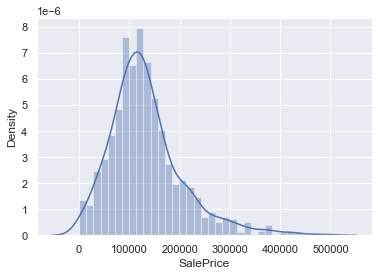

In [13]:
sns.distplot(df_train['SalePrice'])

print('Skewness: %f' %df_train['SalePrice'].skew())  #歪度
print('Kurtosis: %f' %df_train['SalePrice'].kurt())  #尖度

In [14]:
'''
'SalePrice'は正規分布に従わないためML回帰モデルではパフォーマンスが低下する可能性がある
対数変換を行うと結果がよくなるかも
'''

"\n'SalePrice'は正規分布に従わないためML回帰モデルではパフォーマンスが低下する可能性がある\n対数変換を行うと結果がよくなるかも\n"

Skewness: -12.497639
Kurtosis: 158.489048


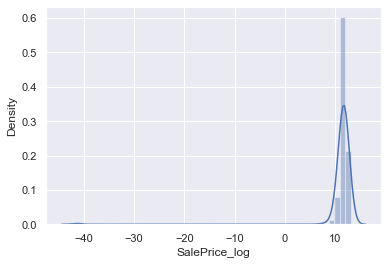

In [15]:
df_train['SalePrice'].replace(0,0.000000000000000001,inplace=True)
df_train['SalePrice_log'] = np.log(df_train['SalePrice'])


sns.distplot(df_train['SalePrice_log'])


print('Skewness: %f' %df_train['SalePrice_log'].skew())  #歪度
print('Kurtosis: %f' %df_train['SalePrice_log'].kurt())  #尖度

df_train.drop('SalePrice',axis=1,inplace=True)

In [16]:
numerical_feats = df_train.dtypes[df_train.dtypes != 'object'].index
print('Number of Numerical features: ',len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == 'object'].index
print('Number of Categorical features: ',len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


In [17]:
print(df_train[numerical_feats].columns)
print('#'*80)
print(df_train[categorical_feats].columns)

Index(['index', 'Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo Sold', 'Yr Sold', 'SalePrice_log'],
      dtype='object')
################################################################################
Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Ty

In [18]:
df_train[numerical_feats].head()

,index,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice_log
0,0,2827,911587246,18,68,9241,6,4,1999,2010,19,30,0,1343,523,551,0,1283,0,2,0,3,1,5,0,1979,3,534,253,38,0,0,0,0,0,2,2005,11.461064
1,3,1239,505139030,22,50,6249,7,5,1941,2005,17,528,0,1202,815,39,1,1075,0,2,0,3,2,4,0,1951,2,188,14,0,0,1,0,0,0,5,2009,11.997029
2,7,2768,524499845,64,55,8757,5,6,1980,2004,16,1866,0,825,786,0,2,1210,0,1,0,3,0,7,0,1977,2,300,343,0,5,0,0,0,0,7,2009,11.772362
3,10,2120,890941778,60,43,12946,6,4,2009,1954,340,65,650,787,1446,0,3,1203,0,1,1,3,1,8,0,1976,1,706,11,0,2,0,0,0,0,6,2007,11.733065
4,11,407,902420295,64,137,5902,8,4,2011,1964,12,0,97,713,563,381,2,939,0,0,0,3,1,6,2,1956,2,447,4,0,4,0,0,2,0,5,2007,11.890533


In [19]:
df_train[categorical_feats].head()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
0,RL,Pave,Grvl,IR2,Lvl,AllPub,Corner,Gtl,Mitchel,Norm,Norm,1Fam,2Story,Gable,CompShg,AsbShng,VinylSd,BrkFace,TA,TA,PConc,TA,TA,Av,GLQ,Unf,GasA,Ex,N,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,MetalSd,None,Gd,TA,CBlock,Gd,TA,Av,Rec,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,P,Gd,MnPrv,Shed,WD,Partial
2,RL,Pave,Grvl,Reg,Lvl,AllPub,CulDSac,Gtl,MeadowV,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,MetalSd,None,Gd,TA,BrkTil,TA,TA,Mn,ALQ,Unf,GasA,TA,Y,FuseA,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,RL,Grvl,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1.5Fin,Hip,CompShg,VinylSd,HdBoard,Stone,Gd,TA,PConc,TA,TA,Gd,Unf,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
4,RM,Pave,Grvl,Reg,Low,AllPub,Inside,Gtl,Edwards,RRAe,Norm,1Fam,1Story,Gable,CompShg,VinylSd,CmentBd,None,TA,Gd,BrkTil,TA,TA,Mn,BLQ,BLQ,GasA,Ex,Y,FuseA,Gd,Typ,TA,Attchd,Fin,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


In [20]:
#欠損値をリスト
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['total','percent'])
missing_data.head(20)

,total,percent
index,0,0.0
Heating QC,0,0.0
Garage Yr Blt,0,0.0
Garage Type,0,0.0
Fireplace Qu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRms AbvGrd,0,0.0
Kitchen Qual,0,0.0
Kitchen AbvGr,0,0.0


In [21]:
#欠損値がある場合
'''
#欠損値をNoneで補完
cols_fillna = ['...','...',.....,'...']

for cols in cols_fillna:
    df_train[cols].fillna('None',inplace=True)
    df_test[cols].fillna('None',inplace=True)
    
#欠損値を平均で補完
df_train.fillna(df_train.mean(),inplace=True)
df_test.fillna(df_test.mean(),inplace=True)
'''

"\n#欠損値をNoneで補完\ncols_fillna = ['...','...',.....,'...']\n\nfor cols in cols_fillna:\n    df_train[cols].fillna('None',inplace=True)\n    df_test[cols].fillna('None',inplace=True)\n    \n#欠損値を平均で補完\ndf_train.fillna(df_train.mean(),inplace=True)\ndf_test.fillna(df_test.mean(),inplace=True)\n"

In [22]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0


In [23]:
for col in numerical_feats:
    print('{:15}'.format(col),
         'Skewness : {:05.2f}'.format(df_train[col].skew()),
         '    ',
         'Kurtness: {:06.2f}'.format(df_train[col].kurt())
         )

index           Skewness : -0.02      Kurtness: -01.20
Order           Skewness : -0.40      Kurtness: -01.09
PID             Skewness : -1.15      Kurtness: -00.64
MS SubClass     Skewness : 01.53      Kurtness: 002.46
Lot Frontage    Skewness : 00.30      Kurtness: 002.48
Lot Area        Skewness : 04.17      Kurtness: 032.76
Overall Qual    Skewness : 00.19      Kurtness: 000.17
Overall Cond    Skewness : 00.50      Kurtness: 003.07
Year Built      Skewness : -0.66      Kurtness: 000.07
Year Remod/Add  Skewness : -0.64      Kurtness: -01.04
Mas Vnr Area    Skewness : 02.62      Kurtness: 007.08
BsmtFin SF 1    Skewness : 00.54      Kurtness: -00.70
Bsmt Unf SF     Skewness : 01.23      Kurtness: 001.42
Total Bsmt SF   Skewness : 00.55      Kurtness: 001.24
1st Flr SF      Skewness : 00.86      Kurtness: 001.07
2nd Flr SF      Skewness : 00.93      Kurtness: 000.60
Low Qual Fin SF Skewness : 18.03      Kurtness: 340.97
Gr Liv Area     Skewness : 00.84      Kurtness: 000.59
Bsmt Full 

Skewness: 0.840407
Kurtness: 0.588130


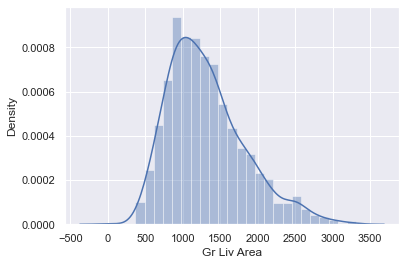

In [24]:
sns.distplot(df_train['Gr Liv Area'])

print('Skewness: %f' % df_train['Gr Liv Area'].skew())
print('Kurtness: %f' % df_train['Gr Liv Area'].kurt())

Skewness: 4.165305
Kurtness: 32.764068


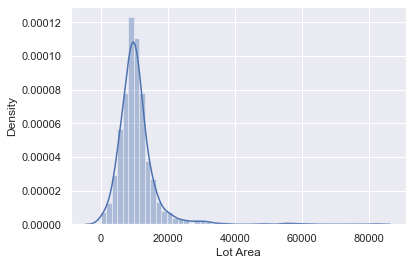

In [25]:
sns.distplot(df_train['Lot Area'])

print('Skewness: %f' % df_train['Lot Area'].skew())
print('Kurtness: %f' % df_train['Lot Area'].kurt())

In [26]:
for df in [df_train,df_test]:
    df['Lot Area'].replace(0,0.000000000000001,inplace=True)
    df['LotArea_log'] = np.log(df['Lot Area'])
    df.drop('Lot Area',inplace=True,axis=1)
    df['Gr Liv Area'].replace(0,0.000000000000001,inplace=True)
    df['GrLivArea_log'] = np.log(df['Gr Liv Area'])
    df.drop('Gr Liv Area',inplace=True,axis=1)
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

Skewness: -16.129189
Kurtness: 270.250005


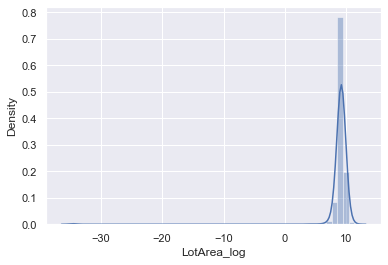

In [27]:
sns.distplot(df_train['LotArea_log'])

print('Skewness: %f' % df_train['LotArea_log'].skew())
print('Kurtness: %f' % df_train['LotArea_log'].kurt())

Skewness: -29.844919
Kurtness: 983.444265


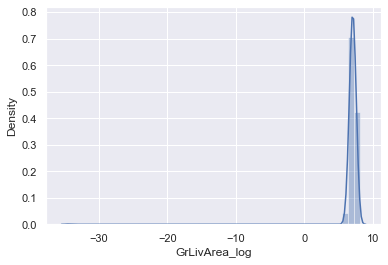

In [28]:
sns.distplot(df_train['GrLivArea_log'])

print('Skewness: %f' % df_train['GrLivArea_log'].skew())
print('Kurtness: %f' % df_train['GrLivArea_log'].kurt())

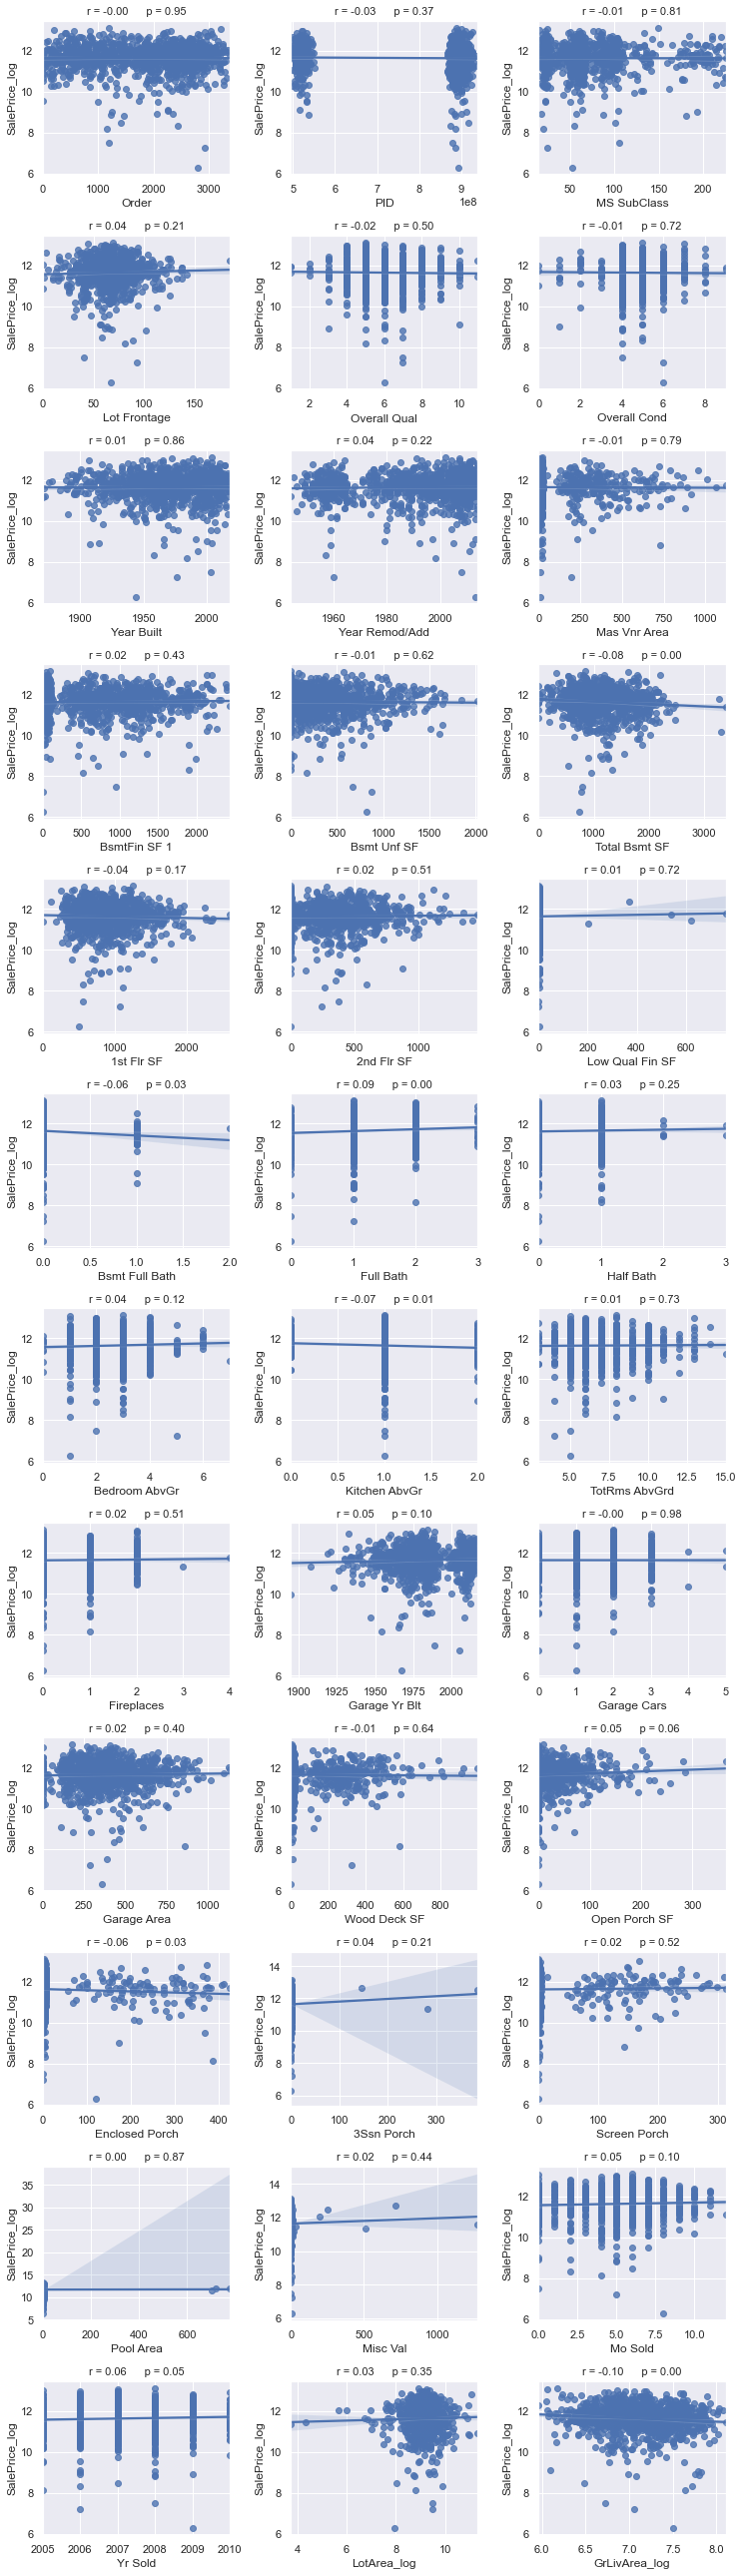

In [32]:
nr_rows = 12
nr_cols = 3

fig,axs = plt.subplots(nr_rows,nr_cols,figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['index','SalePrice','SalePrice_log']
li_plot_num_feats = [c for c in list(li_num_feats) if c not in li_not_plot]

df_train = df_train.drop(df_train[(df_train['SalePrice_log']<0) | (df_train['GrLivArea_log']<0) | (df_train['LotArea_log']<0)].index)


for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols+c
        if i < len(numerical_feats):
            sns.regplot(df_train[li_plot_num_feats[i]],df_train[target],ax=axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]],df_train[target])
            str_title = 'r = ' + '{0:.2f}'.format(stp[0]) + '      ' + 'p = ' + '{0:.2f}'.format(stp[1])  #r:相関係数  p:有意確率
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()
plt.show()

In [35]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols,target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [36]:
print(ser_corr)
print('#'*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print('#'*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

SalePrice_log      1.000000
GrLivArea_log      0.103390
Full Bath          0.091601
Total Bsmt SF      0.082883
Kitchen AbvGr      0.071488
Enclosed Porch     0.063955
Bsmt Full Bath     0.062194
Yr Sold            0.056939
Open Porch SF      0.053870
Mo Sold            0.047223
Garage Yr Blt      0.047137
Bedroom AbvGr      0.044679
1st Flr SF         0.039418
3Ssn Porch         0.036732
Lot Frontage       0.036038
Year Remod/Add     0.035938
Half Bath          0.033615
index              0.031804
LotArea_log        0.027265
PID                0.025988
Garage Area        0.024366
BsmtFin SF 1       0.022700
Misc Val           0.022463
Overall Qual       0.019637
2nd Flr SF         0.019209
Fireplaces         0.019150
Screen Porch       0.018781
Bsmt Unf SF        0.014331
Wood Deck SF       0.013727
Overall Cond       0.010491
Low Qual Fin SF    0.010327
TotRms AbvGrd      0.009937
Mas Vnr Area       0.007705
MS SubClass        0.007031
Year Built         0.005171
Pool Area          0

In [37]:
#カテゴリ変数のユニーク数
for catg in list(categorical_feats):
    print(df_train[catg].value_counts())
    print('*'*50)

RL         966
RM         172
FV          19
C (all)     13
RH          13
A (agr)      5
Name: MS Zoning, dtype: int64
**************************************************
Pave    1183
Grvl       5
Name: Street, dtype: int64
**************************************************
Grvl    1149
Pave      39
Name: Alley, dtype: int64
**************************************************
Reg    914
IR1    240
IR2     26
IR3      8
Name: Lot Shape, dtype: int64
**************************************************
Lvl    954
Bnk    125
HLS     72
Low     37
Name: Land Contour, dtype: int64
**************************************************
AllPub    1177
NoSewr      11
Name: Utilities, dtype: int64
**************************************************
Inside     920
Corner     149
CulDSac     89
FR2         21
FR3          9
Name: Lot Config, dtype: int64
**************************************************
Gtl    1135
Mod      41
Sev      12
Name: Land Slope, dtype: int64
**********************************

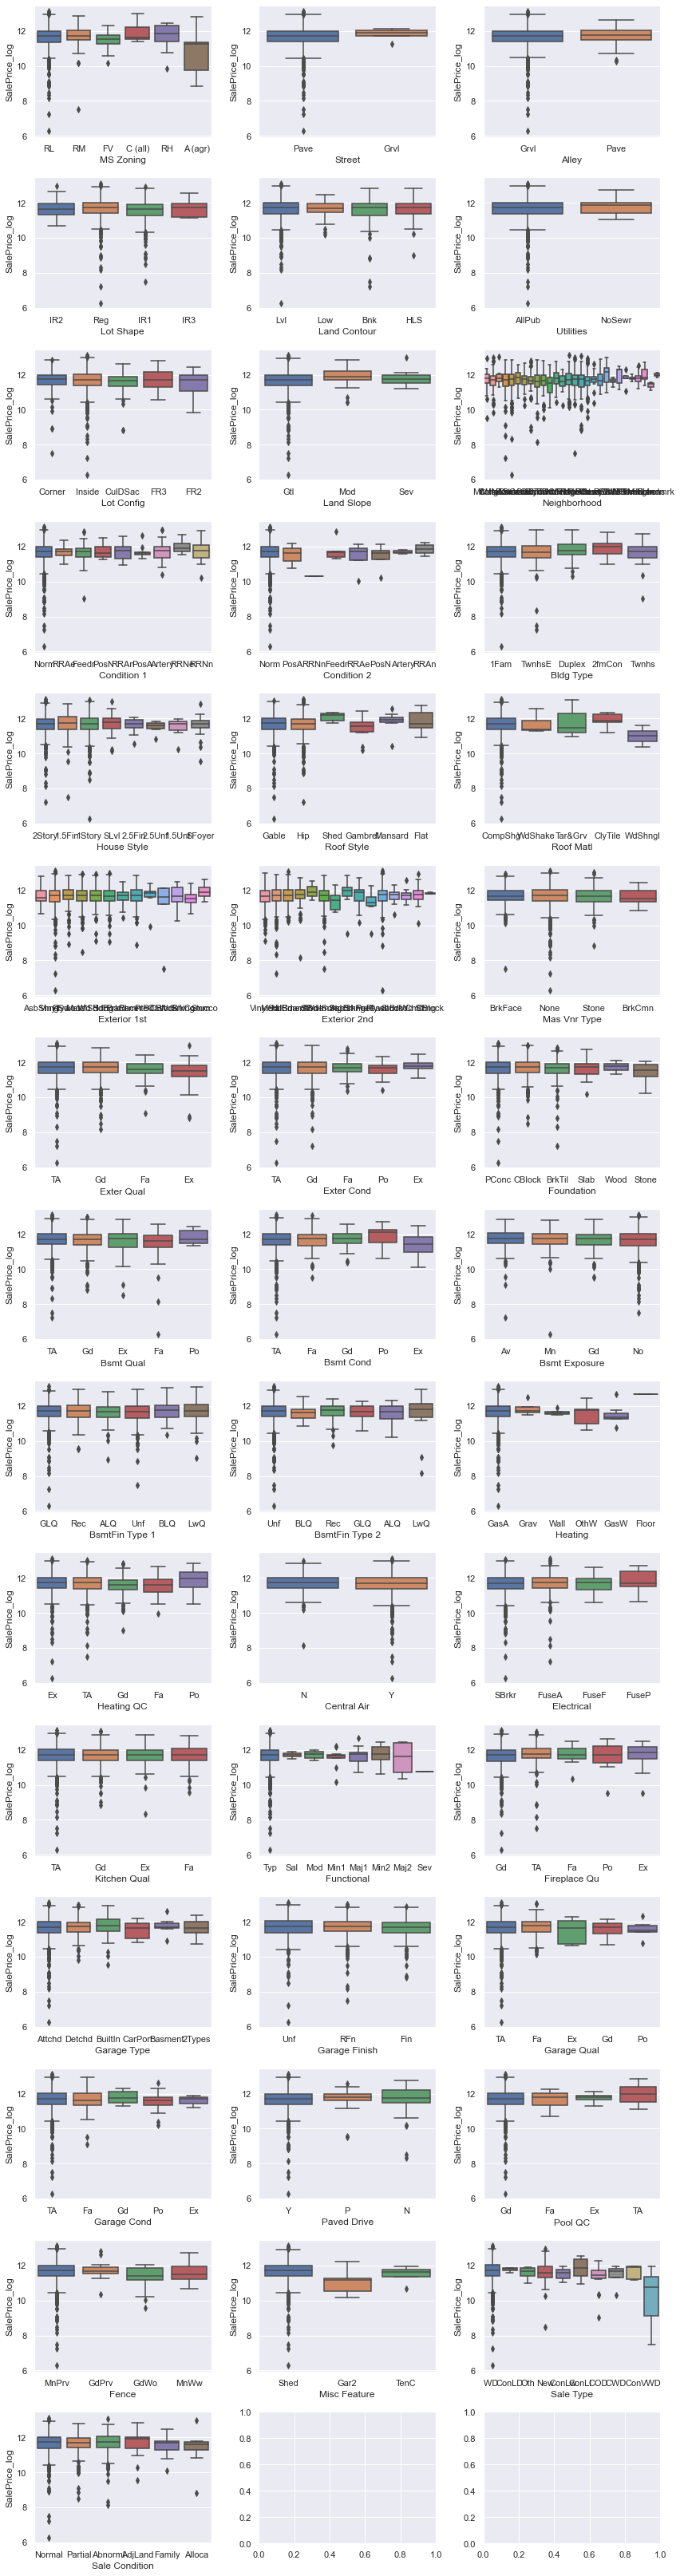

In [38]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig,axs = plt.subplots(nr_rows,nr_cols,figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i],y=target,data=df_train,ax=axs[r][c])
            
plt.tight_layout()
plt.show()

In [39]:
catg_strong_corr = ['MS Zoning','Condition 2','Roof Style','Roof Matl','Exterior 2nd','Heating','Functional',
                   'Garage Qual','Fence','Misc Feature','Sale Type']

catg_weak_corr = ['Street','Alley','Lot Shape','Land Contour','Utilities','Lot Config',
                 'Land Slope','Neighborhood','Condition 1','Bldg Type','House Style','Exterior 1st','Mas Vnr Type','Exter Qual',
                 'Exter Cond','Foundation','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
                 'Central Air','Electrical','Kitchen Qual','Fireplace Qu','Garage Type','Garage Finish','Garage Cond',
                 'Paved Drive','Pool QC','Sale Condition']

In [46]:
nr_feats = len(cols_abv_corr_limit)

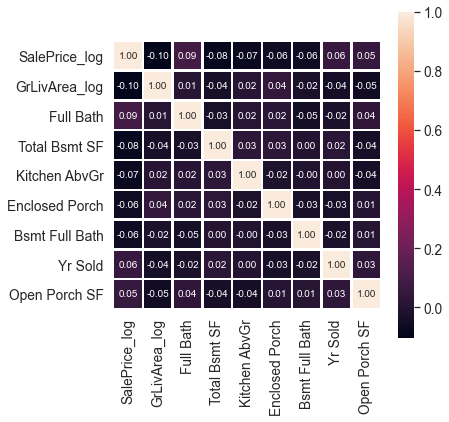

In [47]:
plot_corr_matrix(df_train,nr_feats,target)

In [48]:
id_test = df_test['index']

to_drop_num = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['index'] + to_drop_num + to_drop_catg

for df in [df_train,df_test]:
    df.drop(cols_to_drop,inplace=True,axis=1)

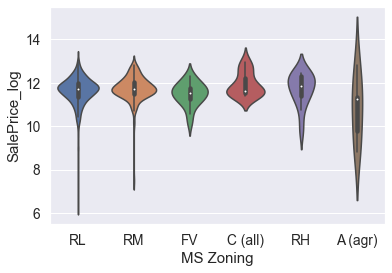

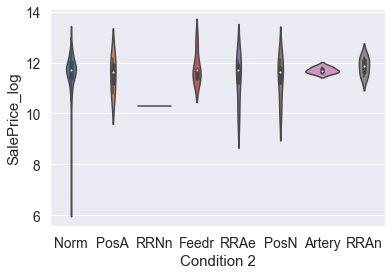

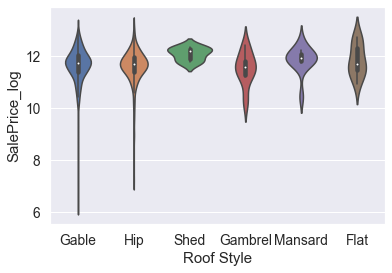

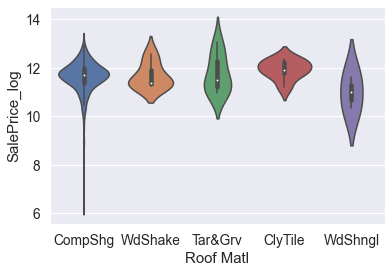

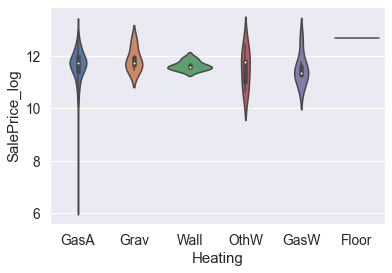

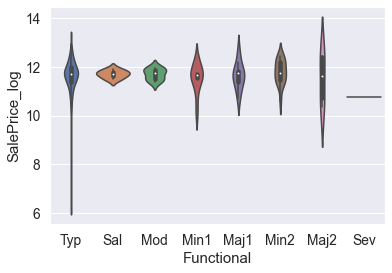

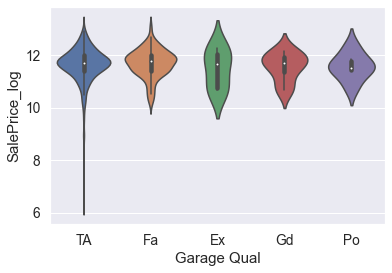

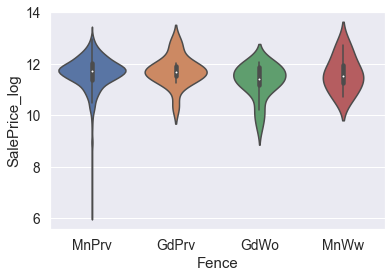

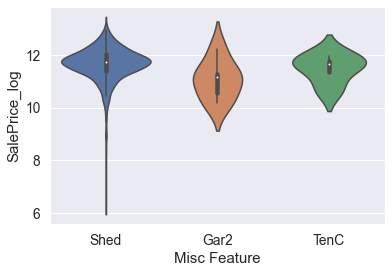

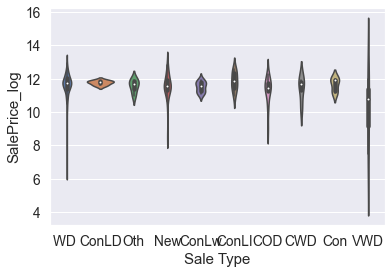

In [50]:
catg_list = catg_strong_corr.copy()
#catg_list.remove('Neighborhood')  #変数の多いものは取り除くべき？
catg_list.remove('Exterior 2nd')

for catg in catg_list:
    #sns.catplot(x=catg,y=target,data=df_train,kind='boxen')
    sns.violinplot(x=catg,y=target,data=df_train)
    plt.show()
    #sns.boxenplot(x=catg,y=target,data=df_train)
    #bp = df_train.boxplot(column=[target],by=catg)

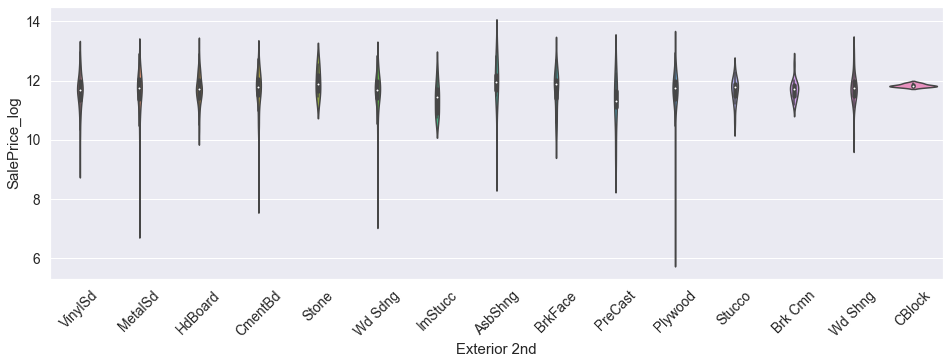

In [51]:
fig,ax = plt.subplots()
fig.set_size_inches(16,5)
sns.violinplot(x='Exterior 2nd',y=target,data=df_train,ax=ax)
plt.xticks(rotation=45)
plt.show()

In [52]:
for catg in catg_list:
    g = df_train.groupby(catg)[target].mean()
    print(g)

MS Zoning
A (agr)    10.800458
C (all)    11.921238
FV         11.481488
RH         11.702918
RL         11.621742
RM         11.738365
Name: SalePrice_log, dtype: float64
Condition 2
Artery    11.703071
Feedr     11.795018
Norm      11.638552
PosA      11.518571
PosN      11.405063
RRAe      11.401431
RRAn      11.853956
RRNn      10.309719
Name: SalePrice_log, dtype: float64
Roof Style
Flat       11.844685
Gable      11.644914
Gambrel    11.522046
Hip        11.612587
Mansard    11.864677
Shed       12.090010
Name: SalePrice_log, dtype: float64
Roof Matl
ClyTile    11.933871
CompShg    11.635471
Tar&Grv    11.749750
WdShake    11.671059
WdShngl    10.990454
Name: SalePrice_log, dtype: float64
Heating
Floor    12.704901
GasA     11.636587
GasW     11.509121
Grav     11.869432
OthW     11.529674
Wall     11.643479
Name: SalePrice_log, dtype: float64
Functional
Maj1    11.637115
Maj2    11.503725
Min1    11.542798
Min2    11.791004
Mod     11.705105
Sal     11.710021
Sev     10.767832
T

In [53]:
g = df_train.groupby('Exterior 2nd')[target].mean()
print(g)

Exterior 2nd
AsbShng    11.791923
Brk Cmn    11.701646
BrkFace    11.646526
CBlock     11.836471
CmentBd    11.663204
HdBoard    11.706501
ImStucc    11.359200
MetalSd    11.587940
Plywood    11.650031
PreCast    11.201431
Stone      11.950083
Stucco     11.656067
VinylSd    11.628801
Wd Sdng    11.614975
Wd Shng    11.712228
Name: SalePrice_log, dtype: float64


In [54]:
#condition2 
cond2_catg1 = ['RRNn']
cond2_catg2 = ['PosN','RRAe']
cond2_catg3 = ['PosA','Norm']

#Roof Style
RS_catg2 = ['Flat','Mansard']
RS_catg3 = ['Shed']

#Fanctional
Fnc_catg1 = ['Sev']
Fnc_catg2 = ['Maj2','Min1']
Fnc_catg3 = ['Maj1','Typ']

#Garage Qual
GQ_catg1 = ['Ex']
GQ_catg2 = ['Gd','Po']

#Sale Type
ST_catg1 = ['VWD']
ST_catg2 = ['COD','CWD']
ST_catg3 = ['ConLw']
ST_catg5 = ['Con','WD']
ST_catg6 = ['ConLD','ConLI']

#Exterior 2nd
Ex2_catg1 = ['ImStucc','PreCast']
Ex2_catg3 = ['AsbShng','CBlock','Stone']

In [57]:
for df in [df_train,df_test]:
    df['MSZ_num'] = 2
    df.loc[(df['MS Zoning']=='A (agr)'),'MSZ_num'] = 1
    
    df['Condition2_num'] = 4
    df.loc[(df['Condition 2'].isin(cond2_catg1)),'Condition2_num'] = 1
    df.loc[(df['Condition 2'].isin(cond2_catg2)),'Condition2_num'] = 2
    df.loc[(df['Condition 2'].isin(cond2_catg3)),'Condition2_num'] = 3
    
    df['RoofStyle_num'] = 1
    df.loc[(df['Roof Style'].isin(RS_catg2)),'RoofStyle_num'] = 2
    df.loc[(df['Roof Style'].isin(RS_catg3)),'RoofStyle_num'] = 3
    
    df['RoofMatl_num'] = 2
    df.loc[(df['Roof Matl']=='WdShngl'),'RoofMatl_num'] = 1
    df.loc[(df['Roof Matl']=='ClyTile'),'RoofMatl_num'] = 3
    
    df['Heating_num'] = 1
    df.loc[(df['Heating']=='Floor'),'Heating_num'] = 2
    
    df['Functional_num'] = 4
    df.loc[(df['Functional'].isin(Fnc_catg1)),'Functional_num'] = 1
    df.loc[(df['Functional'].isin(Fnc_catg2)),'Functional_num'] = 2
    df.loc[(df['Functional'].isin(Fnc_catg3)),'Functional_num'] = 3
    
    df['GarageQual_num'] = 3
    df.loc[(df['Garage Qual'].isin(GQ_catg1)),'GarageQual_num'] = 1
    df.loc[(df['Garage Qual'].isin(GQ_catg2)),'GarageQual_num'] = 2
    
    df['Fence_num'] = 2
    df.loc[(df['Fence']=='GdWo'),'Fence_num'] = 1
    
    df['MiscFeature_num'] = 2
    df.loc[(df['Misc Feature']=='Gar2'),'MiscFeature_num'] = 1
    
    df['SaleType_num'] = 4
    df.loc[(df['Sale Type'].isin(ST_catg1)),'SaleType_num'] = 1
    df.loc[(df['Sale Type'].isin(ST_catg2)),'SaleType_num'] = 2
    df.loc[(df['Sale Type'].isin(ST_catg3)),'SaleType_num'] = 3
    df.loc[(df['Sale Type'].isin(ST_catg5)),'SaleType_num'] = 5
    df.loc[(df['Sale Type'].isin(ST_catg6)),'SaleType_num'] = 6
    
    df['Exterior2nd_num'] = 2
    df.loc[(df['Exterior 2nd'].isin(Ex2_catg1)),'Exterior2nd_num'] = 1
    df.loc[(df['Exterior 2nd'].isin(Ex2_catg3)),'Exterior2nd_num'] = 3

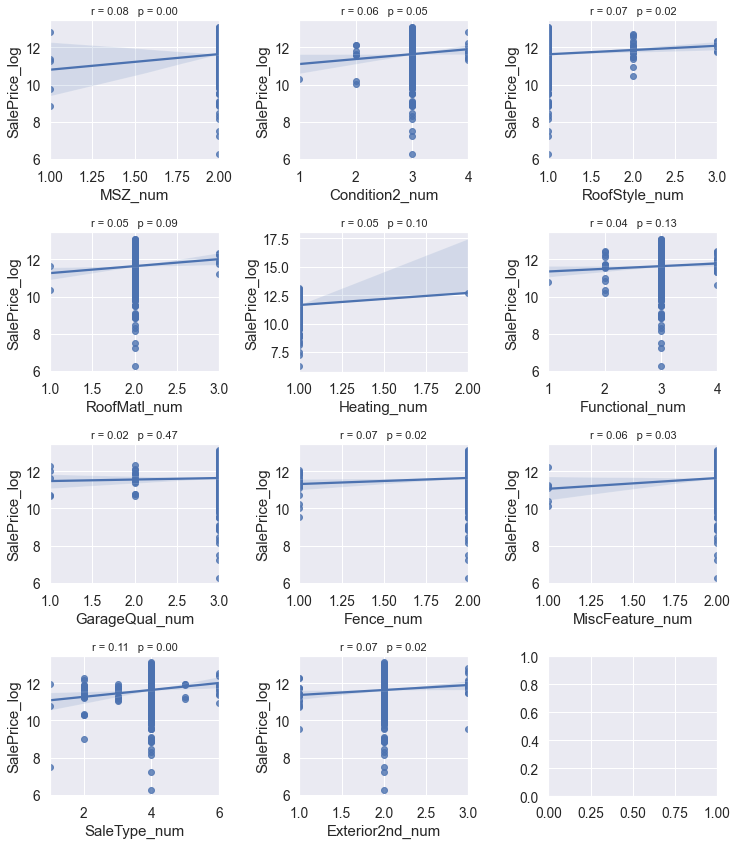

In [59]:
new_cols_num = ['MSZ_num','Condition2_num','RoofStyle_num','RoofMatl_num','Heating_num','Functional_num',
               'GarageQual_num','Fence_num','MiscFeature_num','SaleType_num','Exterior2nd_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows,nr_cols,figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols + c
        if i < len(new_cols_num):
            sns.regplot(df_train[new_cols_num[i]],df_train[target],ax=axs[r][c])
            stp = stats.pearsonr(df_train[new_cols_num[i]],df_train[target])
            str_title = 'r = ' + '{0:.2f}'.format(stp[0]) + '   ' + 'p = ' + '{0:.2f}'.format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()
plt.show()

In [61]:
catg_cols_to_drop = ['MS Zoning','Condition 2','Roof Style','Roof Matl','Heating','Functional',
                    'Garage Qual','Fence','Misc Feature','Sale Type','Exterior 2nd']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols,target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values<=min_val_corr].index)

for df in [df_train,df_test]:
    df.drop(catg_cols_to_drop,inplace=True,axis=1)
    df.drop(cols_bel_corr_limit_1,inplace=True,axis=1)

SalePrice_log      1.000000
SaleType_num       0.108682
GrLivArea_log      0.103390
Full Bath          0.091601
Total Bsmt SF      0.082883
MSZ_num            0.082784
Kitchen AbvGr      0.071488
RoofStyle_num      0.069752
Fence_num          0.067380
Exterior2nd_num    0.066808
Enclosed Porch     0.063955
MiscFeature_num    0.062590
Bsmt Full Bath     0.062194
Condition2_num     0.057516
Yr Sold            0.056939
Open Porch SF      0.053870
RoofMatl_num       0.049673
Heating_num        0.047172
Functional_num     0.043564
GarageQual_num     0.021181
Name: SalePrice_log, dtype: float64


In [62]:
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols,target)[target]

print(ser_corr_2)

SalePrice_log      1.000000
SaleType_num       0.108682
GrLivArea_log      0.103390
Full Bath          0.091601
Total Bsmt SF      0.082883
MSZ_num            0.082784
Kitchen AbvGr      0.071488
RoofStyle_num      0.069752
Fence_num          0.067380
Exterior2nd_num    0.066808
Enclosed Porch     0.063955
MiscFeature_num    0.062590
Bsmt Full Bath     0.062194
Condition2_num     0.057516
Yr Sold            0.056939
Open Porch SF      0.053870
Name: SalePrice_log, dtype: float64


In [63]:
df_train.head()

,Total Bsmt SF,Bsmt Full Bath,Full Bath,Kitchen AbvGr,Open Porch SF,Enclosed Porch,Yr Sold,SalePrice_log,GrLivArea_log,MSZ_num,Condition2_num,RoofStyle_num,Fence_num,MiscFeature_num,SaleType_num,Exterior2nd_num
0,1343,0,2,1,38,0,2005,11.461064,7.156956,2,3,1,2,2,4,2
1,1202,0,2,2,0,0,2009,11.997029,6.980076,2,3,1,2,2,4,2
2,825,0,1,0,0,5,2009,11.772362,7.098376,2,3,1,2,2,4,2
3,787,0,1,1,0,2,2007,11.733065,7.092574,2,3,1,2,2,4,2
4,713,0,0,1,0,4,2007,11.890533,6.844815,2,3,1,2,2,4,2


In [64]:
df_test.head()

,Total Bsmt SF,Bsmt Full Bath,Full Bath,Kitchen AbvGr,Open Porch SF,Enclosed Porch,Yr Sold,GrLivArea_log,MSZ_num,Condition2_num,RoofStyle_num,Fence_num,MiscFeature_num,SaleType_num,Exterior2nd_num
0,508,0,1,1,61,3,2005,7.222566,2,3,1,2,2,4,2
1,692,0,1,1,0,0,2006,7.026427,2,3,1,2,2,6,2
2,1015,0,2,1,0,3,2006,6.956545,2,3,1,2,2,4,2
3,1040,0,2,1,0,0,2006,6.565265,2,3,1,2,2,4,2
4,719,0,1,0,0,0,2006,7.928406,2,3,1,2,2,4,2


In [67]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print(corr_abs.nlargest(nr_all_cols,target)[target])

SalePrice_log      1.000000
SaleType_num       0.108682
GrLivArea_log      0.103390
Full Bath          0.091601
Total Bsmt SF      0.082883
MSZ_num            0.082784
Kitchen AbvGr      0.071488
RoofStyle_num      0.069752
Fence_num          0.067380
Exterior2nd_num    0.066808
Enclosed Porch     0.063955
MiscFeature_num    0.062590
Bsmt Full Bath     0.062194
Condition2_num     0.057516
Yr Sold            0.056939
Open Porch SF      0.053870
Name: SalePrice_log, dtype: float64


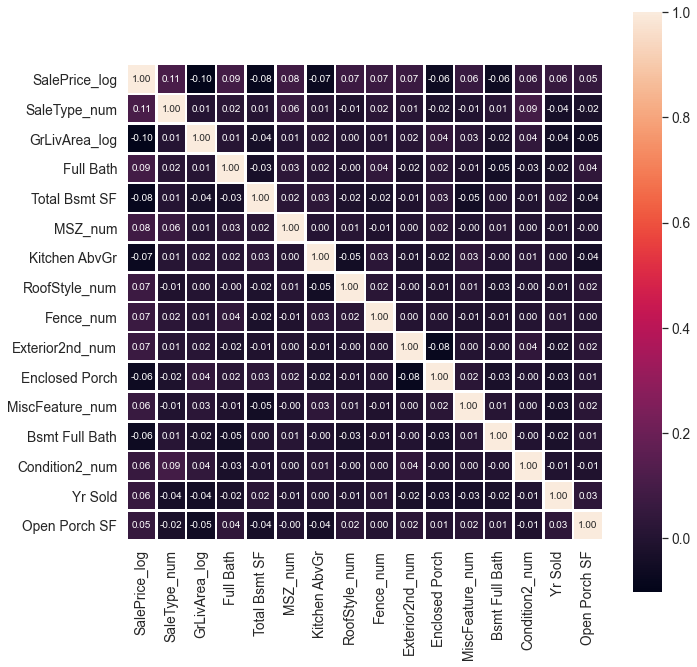

In [68]:
nr_feats = len(df_train.columns)
plot_corr_matrix(df_train,nr_feats,target)

In [69]:
#もし目的変数以外と強い相関をもっている変数があれば

cols = corr_abs.nlargest(nr_all_cols,target)[target].index
cols = list(cols)

'''
if drop_similar == 1:
    for col in [#ここに目的変数以外と強い相関をもっている変数を入れる]:
        if col in cols:
            cols.remove(col)

cols = list(cols)
print(cols)
'''

'\nif drop_similar == 1:\n    for col in [#ここに目的変数以外と強い相関をもっている変数を入れる]:\n        if col in cols:\n            cols.remove(col)\n\ncols = list(cols)\nprint(cols)\n'

In [70]:
feats = cols.copy()
feats.remove('SalePrice_log')

print(feats)

['SaleType_num', 'GrLivArea_log', 'Full Bath', 'Total Bsmt SF', 'MSZ_num', 'Kitchen AbvGr', 'RoofStyle_num', 'Fence_num', 'Exterior2nd_num', 'Enclosed Porch', 'MiscFeature_num', 'Bsmt Full Bath', 'Condition2_num', 'Yr Sold', 'Open Porch SF']


In [71]:
df_train_ml = df_train[feats].copy()
df_test_ml = df_test[feats].copy()

y = df_train[target]

In [72]:
'''
#one hot encoderを適用する場合

all_data = pd.concat((df_train[feats],df_test[feats]))

li_get_dummies = ['SaleType_num', 'GrLivArea_log', 'Full Bath', 'Total Bsmt SF', 'MSZ_num', 'Kitchen AbvGr', 'RoofStyle_num', 'Fence_num', 'Exterior2nd_num', 'Enclosed Porch',
                'MiscFeature_num', 'Bsmt Full Bath', 'Condition2_num', 'Yr Sold', 'Open Porch SF']
all_data = pd.get_dummies(all_data,columns=li_get_dummies,drop_first=True)

df_train_ml = all_data[:df_train.shape[0]]
df_test_ml = all_data[df_train.shape[0]:]
'''

"\n#one hot encoderを適用する場合\n\nall_data = pd.concat((df_train[feats],df_test[feats]))\n\nli_get_dummies = ['SaleType_num', 'GrLivArea_log', 'Full Bath', 'Total Bsmt SF', 'MSZ_num', 'Kitchen AbvGr', 'RoofStyle_num', 'Fence_num', 'Exterior2nd_num', 'Enclosed Porch',\n                'MiscFeature_num', 'Bsmt Full Bath', 'Condition2_num', 'Yr Sold', 'Open Porch SF']\nall_data = pd.get_dummies(all_data,columns=li_get_dummies,drop_first=True)\n\ndf_train_ml = all_data[:df_train.shape[0]]\ndf_test_ml = all_data[df_train.shape[0]:]\n"

In [74]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [75]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.074562,0.131719,1.427305,0.501216,0.065012,-0.074460,-0.146616,0.137361,-0.010258,-0.328541,0.071247,-0.174491,-0.011845,-1.531294,0.435881
1,0.074562,-0.324239,1.427305,0.190111,0.065012,2.316299,-0.146616,0.137361,-0.010258,-0.328541,0.071247,-0.174491,-0.011845,1.404047,-0.515178
2,0.074562,-0.019289,-0.098922,-0.641710,0.065012,-2.465218,-0.146616,0.137361,-0.010258,-0.259296,0.071247,-0.174491,-0.011845,1.404047,-0.515178
3,0.074562,-0.034245,-0.098922,-0.725554,0.065012,-0.074460,-0.146616,0.137361,-0.010258,-0.300843,0.071247,-0.174491,-0.011845,-0.063624,-0.515178
4,0.074562,-0.672909,-1.625149,-0.888829,0.065012,-0.074460,-0.146616,0.137361,-0.010258,-0.273145,0.071247,-0.174491,-0.011845,-0.063624,-0.515178


In [76]:
X = df_train_ml.copy()
y = df_train[target]
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]
X_test_sc = df_test_ml.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1199
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SaleType_num     1188 non-null   int64  
 1   GrLivArea_log    1188 non-null   float64
 2   Full Bath        1188 non-null   int64  
 3   Total Bsmt SF    1188 non-null   int64  
 4   MSZ_num          1188 non-null   int64  
 5   Kitchen AbvGr    1188 non-null   int64  
 6   RoofStyle_num    1188 non-null   int64  
 7   Fence_num        1188 non-null   int64  
 8   Exterior2nd_num  1188 non-null   int64  
 9   Enclosed Porch   1188 non-null   int64  
 10  MiscFeature_num  1188 non-null   int64  
 11  Bsmt Full Bath   1188 non-null   int64  
 12  Condition2_num   1188 non-null   int64  
 13  Yr Sold          1188 non-null   int64  
 14  Open Porch SF    1188 non-null   int64  
dtypes: float64(1), int64(14)
memory usage: 180.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entr

In [77]:
X.head()

,SaleType_num,GrLivArea_log,Full Bath,Total Bsmt SF,MSZ_num,Kitchen AbvGr,RoofStyle_num,Fence_num,Exterior2nd_num,Enclosed Porch,MiscFeature_num,Bsmt Full Bath,Condition2_num,Yr Sold,Open Porch SF
0,4,7.156956,2,1343,2,1,1,2,2,0,2,0,3,2005,38
1,4,6.980076,2,1202,2,2,1,2,2,0,2,0,3,2009,0
2,4,7.098376,1,825,2,0,1,2,2,5,2,0,3,2009,0
3,4,7.092574,1,787,2,1,1,2,2,2,2,0,3,2007,0
4,4,6.844815,0,713,2,1,1,2,2,4,2,0,3,2007,0


In [78]:
X_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.074562,0.131719,1.427305,0.501216,0.065012,-0.074460,-0.146616,0.137361,-0.010258,-0.328541,0.071247,-0.174491,-0.011845,-1.531294,0.435881
1,0.074562,-0.324239,1.427305,0.190111,0.065012,2.316299,-0.146616,0.137361,-0.010258,-0.328541,0.071247,-0.174491,-0.011845,1.404047,-0.515178
2,0.074562,-0.019289,-0.098922,-0.641710,0.065012,-2.465218,-0.146616,0.137361,-0.010258,-0.259296,0.071247,-0.174491,-0.011845,1.404047,-0.515178
3,0.074562,-0.034245,-0.098922,-0.725554,0.065012,-0.074460,-0.146616,0.137361,-0.010258,-0.300843,0.071247,-0.174491,-0.011845,-0.063624,-0.515178
4,0.074562,-0.672909,-1.625149,-0.888829,0.065012,-0.074460,-0.146616,0.137361,-0.010258,-0.273145,0.071247,-0.174491,-0.011845,-0.063624,-0.515178


In [79]:
X_test.head()

,SaleType_num,GrLivArea_log,Full Bath,Total Bsmt SF,MSZ_num,Kitchen AbvGr,RoofStyle_num,Fence_num,Exterior2nd_num,Enclosed Porch,MiscFeature_num,Bsmt Full Bath,Condition2_num,Yr Sold,Open Porch SF
0,4,7.222566,1,508,2,1,1,2,2,3,2,0,3,2005,61
1,6,7.026427,1,692,2,1,1,2,2,0,2,0,3,2006,0
2,4,6.956545,2,1015,2,1,1,2,2,3,2,0,3,2006,0
3,4,6.565265,2,1040,2,1,1,2,2,0,2,0,3,2006,0
4,4,7.928406,1,719,2,0,1,2,2,0,2,0,3,2006,0


In [80]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

In [81]:
#線形モデル
from sklearn.linear_model import LinearRegression

linearg = LinearRegression()
parameters = {'fit_intercept':[True,False],'normalize':[True,False],'copy_X':[True,False]}

grid_linear = GridSearchCV(linearg,parameters,cv=nr_cv,verbose=1,scoring=score_calc)
grid_linear.fit(X,y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.6396353494443522
{'copy_X': True, 'fit_intercept': True, 'normalize': False}
LinearRegression()


In [82]:
linearg_sc = LinearRegression()
parameters = {'fit_intercept':[True,False],'normalize':[True,False],'copy_X':[True,False]}

grid_linear_sc = GridSearchCV(linearg_sc,parameters,cv=nr_cv,verbose=1,scoring=score_calc)
grid_linear_sc.fit(X_sc,y)

sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.639635349444353
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(normalize=True)


In [83]:
linear_all = LinearRegression()
linear_all.fit(X,y)
pred_linear_all = linear_all.predict(X_test)
pred_linear_all[pred_linear_all < 0] = pred_linear_all.mean()

In [85]:
sub_linreg = pd.DataFrame()
sub_linreg['index'] = id_test
sub_linreg['SalePrice'] = pred_linear_all
#sublinreg.to_csv('linreg.csv',index=False)

In [88]:
#リッジ回帰
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1],'normalize':[True,False],'tol':[1e-06,5e-06,1e-05,5e-05]}

grid_ridge = GridSearchCV(ridge,parameters,cv=nr_cv,verbose=1,scoring=score_calc)
grid_ridge.fit(X,y)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.6388937989123944
{'alpha': 0.1, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.1, normalize=True, tol=1e-06)


In [91]:
ridge_sc = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1],'normalize':[True,False],'tol':[1e-06,5e-06,1e-05,5e-05]}

grid_ridge_sc = GridSearchCV(ridge_sc,parameters,cv=nr_cv,verbose=1,scoring=score_calc)
grid_ridge_sc.fit(X_sc,y)

sc_ridge_sc = get_best_score(grid_ridge_sc)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.6388937989123944
{'alpha': 0.1, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.1, normalize=True, tol=1e-06)


In [92]:
pred_ridge_all = grid_ridge.predict(X_test)

In [93]:
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1],'normalize':[True,False],'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}

grid_lasso = GridSearchCV(lasso,parameters,cv=nr_cv,verbose=1,scoring=score_calc)
grid_lasso.fit(X,y)

sc_lasso = get_best_score(grid_lasso)

pred_lasso = grid_lasso.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.6401575108970987
{'alpha': 0.001, 'normalize': False, 'tol': 1e-06}
Lasso(alpha=0.001, tol=1e-06)


In [94]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
parameters = {'alpha':[0.1,1.0,10],'max_iter':[1000000],'l1_ratio':[0.04,0.05],'fit_intercept':[True,False],'normalize':[True,False],
             'tol':[1e-02,1e-03,1e-04]}

grid_enet = GridSearchCV(enet,parameters,cv=nr_cv,verbose=1,scoring=score_calc)
grid_enet.fit(X_sc,y_sc)

sc_enet = get_best_score(grid_enet)

pred_enet = grid_enet.predict(X_test_sc)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.639259017307987
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.0001}
ElasticNet(alpha=0.1, l1_ratio=0.04, max_iter=1000000)


In [97]:
#SGD回帰
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter':[10000],'alpha':[1e-05],'epsilon':[1e-02],'fit_intercept':[True]}

grid_sgd = GridSearchCV(sgd,parameters,cv=nr_cv,verbose=1,scoring=score_calc)
grid_sgd.fit(X_sc,y_sc)

sc_sgd = get_best_score(grid_sgd)

pred_sgd = grid_sgd.predict(X_test_sc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.6398644310660232
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, epsilon=0.01, max_iter=10000)


In [105]:
#木
from sklearn.tree import DecisionTreeRegressor

param_grid = {'max_depth':[7,8,9,10],'max_features':[11,12,13,14],'max_leaf_nodes':[None,12,15,18,20],
             'min_samples_split':[20,25,30],'random_state':[2021]} #'presort'がエラーが出た


grid_dtree = GridSearchCV(DecisionTreeRegressor(),param_grid,cv=nr_cv,refit=True,verbose=1,scoring=score_calc)
grid_dtree.fit(X,y)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(X_test)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.672791491399793
{'max_depth': 7, 'max_features': 11, 'max_leaf_nodes': 12, 'min_samples_split': 20, 'random_state': 2021}
DecisionTreeRegressor(max_depth=7, max_features=11, max_leaf_nodes=12,
                      min_samples_split=20, random_state=2021)


In [164]:
dtree_pred = grid_dtree.predict(X_test)
sub_dtree = pd.DataFrame()
sub_dtree['index'] = id_test
sub_dtree['SalePrice'] = dtree_pred
#sub_dtree.to_csv('dtree.csv',index=False)

In [107]:
from sklearn.ensemble import RandomForestRegressor

prame_grid = {'min_samples_split':[3,4,6,10],'n_estimators':[70,100],'random_state':[2021]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=nr_cv,refit=True,verbose=1,scoring=score_calc)
grid_rf.fit(X,y)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.6590812484495954
{'max_depth': 10, 'max_features': 11, 'max_leaf_nodes': 12, 'min_samples_split': 25, 'random_state': 2021}
RandomForestRegressor(max_depth=10, max_features=11, max_leaf_nodes=12,
                      min_samples_split=25, random_state=2021)


In [153]:
output = Path('output')

pred_rf = grid_rf.predict(X_test)
sub_rf = pd.DataFrame()
sub_rf['index'] = id_test
sub_rf['SalePrice'] = pred_rf

if use_logvals == 1:
    sub_rf['SalePrice'] = np.exp(sub_rf['SalePrice'])
    
    
sub_rf.to_csv(output / 'rf.csv',index=False,header=None)

In [154]:
sub_rf.head()

,index,SalePrice
0,1,120820.230625
1,2,118351.019665
2,4,118856.314288
3,5,120261.911995
4,6,118859.334409


In [116]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors':[3,4,5,6,7,10,15],
             'weights':['uniform','distance'],
             'algorithm':['ball_tree','kd_tree','brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(),param_grid,cv=nr_cv,refit=True,verbose=1,scoring=score_calc)
grid_knn.fit(X_sc,y_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
0.6596298683989983
{'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'uniform'}
KNeighborsRegressor(algorithm='ball_tree', n_neighbors=15)


In [155]:
pred_knn = grid_knn.predict(X_test_sc)

sub_knn = pd.DataFrame()
sub_knn['index'] = id_test
sub_knn['SalePrice'] = pred_knn

if use_logvals == 1:
    sub_knn['SalePrice'] = np.exp(sub_knn['SalePrice'])
    
sub_knn.to_csv(output / 'knn.csv',index=False,header=None)

In [156]:
sub_knn.head()

,index,SalePrice
0,1,98838.747322
1,2,97265.168125
2,4,100785.088867
3,5,100785.088867
4,6,97265.168125


In [124]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel

gpr = GaussianProcessRegressor(random_state=2021,alpha=5e-0,
                               n_restarts_optimizer = 0,
                                optimizer='fmin_l_bfgs_b',
                                copy_X_train=True)

param_grid = {'normalize_y':[True,False],
             'kernel':[DotProduct(),ConstantKernel(1.0,(1e-3,1e3))]}

grid_gpr = GridSearchCV(gpr,param_grid,cv=nr_cv,verbose=1,scoring=score_calc)
grid_gpr.fit(X_sc,y_sc)

sc_gpr = get_best_score(grid_gpr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\81806\anaconda3\envs\kaggle_book\lib\sit

0.6393477965647635
{'kernel': DotProduct(sigma_0=1), 'normalize_y': True}
GaussianProcessRegressor(alpha=5.0, kernel=DotProduct(sigma_0=1),
                         normalize_y=True, random_state=2021)


C:\Users\81806\anaconda3\envs\kaggle_book\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


In [129]:
pred_gpr = grid_gpr.predict(X_test_sc)

sub_gpr = pd.DataFrame()
sub_gpr['index'] = id_test
sub_gpr['SalePrice'] = pred_gpr

if use_logvals == 1:
    sub_gpr['SalePrice'] = np.exp(sub_gpr['SalePrice'])
    
sub_gpr.to_csv(output / 'gpr.csv',index=False)

In [130]:
sub_gpr.head()

,index,SalePrice
0,1,2.795083e+28
1,2,9.584548e+23
2,4,9.002881e+16
3,5,2.991127e+16
4,6,2.168626e+23


In [134]:
list_scores = [sc_linear,sc_ridge,sc_lasso,sc_enet,
             sc_sgd,sc_dtree,sc_rf,sc_knn,sc_gpr]

list_regressor = ['Linear','Ridge','Lasso','ElaNet','SGD','DTr','RF','KNN','GPR']

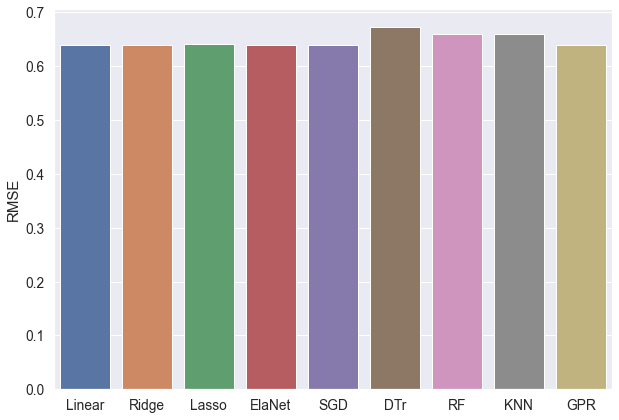

In [135]:
fig,ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressor,y=list_scores,ax=ax)
plt.ylabel('RMSE')
plt.show()

In [138]:
predictions = {'Linear':pred_linear_all,'Ridge':pred_ridge_all,'Lasso':pred_lasso,
              'ElaNet':pred_enet,'SGD':pred_sgd,'DTr':pred_dtree,'RF':pred_rf,
              'KNN':pred_knn,'GPR':pred_gpr}

df_predictions = pd.DataFrame(data=predictions)
df_predictions.corr()

,Linear,Ridge,Lasso,ElaNet,SGD,DTr,RF,KNN,GPR
Linear,1.000000,0.999970,0.991450,0.287953,0.284322,0.260201,0.627873,-0.150244,0.288720
Ridge,0.999970,1.000000,0.991833,0.289459,0.285785,0.260371,0.628129,-0.151178,0.290238
Lasso,0.991450,0.991833,1.000000,0.327777,0.323750,0.275784,0.629227,-0.175042,0.328617
ElaNet,0.287953,0.289459,0.327777,1.000000,0.999818,0.132607,0.261618,-0.637571,0.999994
SGD,0.284322,0.285785,0.323750,0.999818,1.000000,0.129144,0.255983,-0.637377,0.999752
DTr,0.260201,0.260371,0.275784,0.132607,0.129144,1.000000,0.601288,-0.128408,0.133209
RF,0.627873,0.628129,0.629227,0.261618,0.255983,0.601288,1.000000,-0.188976,0.262623
KNN,-0.150244,-0.151178,-0.175042,-0.637571,-0.637377,-0.128408,-0.188976,1.000000,-0.637556
GPR,0.288720,0.290238,0.328617,0.999994,0.999752,0.133209,0.262623,-0.637556,1.000000


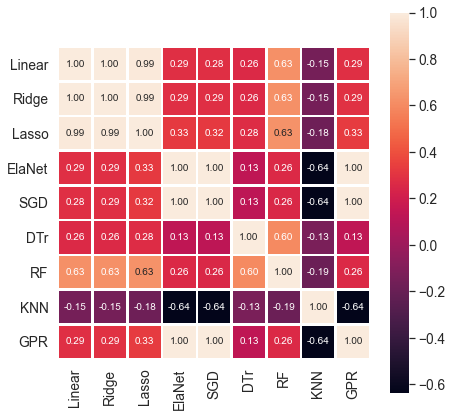

In [142]:
plt.figure(figsize=(7,7))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(),linewidths=1.5,annot=True,square=True,fmt='.2f',annot_kws={'size':10},
           yticklabels=df_predictions.columns,xticklabels=df_predictions.columns)

plt.show()

In [167]:
sub_mean = pd.DataFrame()
sub_mean['index'] = id_test
sub_mean['SalePrice'] = np.round((pred_lasso+pred_enet+pred_rf+pred_sgd)/4.0)

if use_logvals == 1:
    sub_mean['SalePrice'] = np.exp(sub_mean['SalePrice'])
    
sub_mean.to_csv(output / 'mean.csv',index=False,header=None)
sub_mean.head()

,index,SalePrice
0,1,5.834617e+14
1,2,3.931334e+12
2,4,1.318816e+09
3,5,1.318816e+09
4,6,1.446257e+12


,index,SalePrice
0,1,122483.158434
1,2,122483.158434
2,4,122483.158434
3,5,122483.158434
4,6,118290.922640


,index,SalePrice
0,1,1.929826e+25
1,2,3.331265e+20
2,4,9.462153e+12
3,5,2.821481e+12
4,6,6.831101e+19


,index,SalePrice
0,1,5.744260e+23
1,2,8.813582e+19
2,4,8.241213e+13
3,5,3.194025e+13
4,6,2.455383e+19


,index,SalePrice
0,1,117214.854261
1,2,161653.312026
2,4,124795.648019
3,5,132917.198645
4,6,112224.199405
